In [1]:
import mysql.connector

import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

import datetime
now = datetime.date.today()

# Link MySQL and Python
We want to connect MySQL and Python to read the database in Python directly. Using mysql connector seems appropriate here. Let's write a class that will load the database

In [2]:
class MysqlIO:
    def __init__(self, database='test'):
            connection = mysql.connector.connect(host='127.0.0.1', 
                                                 port='3306',
                                                 database=database,
                                                 user='root',
                                                 password='ForSQL!1',
                                                 use_pure=True
                                                 )
            db_info = connection.get_server_info()
            self.connection = connection
            print(f"Retrieval of database {database} Successful")
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe"""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('bank_1999')

Retrieval of database bank_1999 Successful


# Load Data

See WeCloudData_Loan_Default_Data_Exploration.ipynb for more details
- Target variable is 'status' from loan table
- Predictors are:
    - 'amount', 'duration', 'payments', 'frequency', 'loan_days' from loan and account table
    - 'region', 'num_inhabitants', 'ratio_urban_inhabitants', 'avg_salary', 'unemployment_rate', 'entrepreneur_rate', 'crime_rate' from district table
    - 'avg_order_amount from order table
    - 'avg_bal_amount', 'avg_trans_amount', and 'num_trans' from transactions table
    - 'age', 'gender' from client table
    - 'card_type' from card table

### Loan, Account, District Tables

In [4]:
query = """
    select loan_t.date as loan_date, account_t.date as account_date,
    account_id, amount, duration, payments, status, frequency, 
    A3, A4, A10, A11, A12, A13, A14, A15, A16
    from loan_t join account_t using(account_id)
    join demographic_t using(district_id);
    """
loan_account_district_df = db.to_df(query)

loan_account_district_df['defaulted'] = np.where(loan_account_district_df['status'].isin(['A', 'C']), 'no', 'yes')
loan_account_district_df.replace({'POPLATEK MESICNE': 'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'instant'}, 
                        inplace=True)

for col in ['loan_date', 'account_date']:
    loan_account_district_df[col] = pd.to_datetime(loan_account_district_df[col]) 

loan_account_district_df['loan_days'] = (loan_account_district_df['loan_date'] - 
                                            loan_account_district_df['account_date']).dt.days

# District Table Cleanup
loan_account_district_df['unemployment_rate'] = loan_account_district_df[['A12', 'A13']].mean(axis=1)
loan_account_district_df['crime_rate'] = loan_account_district_df[['A15', 'A16']].mean(axis=1) / loan_account_district_df['A4']

loan_account_district_df = loan_account_district_df[['account_id', 
                                                     'status', 'amount', 'duration', 'payments', 'frequency', 'loan_days', 
                                                     'A3', 'A4', 'A10', 'A11', 'unemployment_rate', 
                                                     'A14', 'crime_rate']]
loan_account_district_df.rename(columns = {'A3': 'region', 'A4': 'num_inhabitants', 'A10': 'ratio_urban_inhabitants', 
                              'A11': 'avg_salary', 'A14': 'entrepreneur_rate'}, inplace=True)

loan_account_district_df['defaulted'] = np.where(loan_account_district_df['status'].isin(['A', 'C']), 'no', 'yes')
display(loan_account_district_df.head())

,account_id,status,amount,duration,payments,frequency,loan_days,region,num_inhabitants,ratio_urban_inhabitants,avg_salary,unemployment_rate,entrepreneur_rate,crime_rate,defaulted
0,1787,B,96396,12,8033.00,weekly,105,west Bohemia,94812,81.8,9650,0.99,100,0.030529,yes
1,1801,A,165960,36,4610.00,monthly,148,east Bohemia,112709,73.5,8369,0.99,117,0.024275,no
2,9188,A,127080,60,2118.00,monthly,170,east Bohemia,77917,53.5,8390,0.99,132,0.026965,no
3,1843,A,105804,36,2939.00,monthly,185,central Bohemia,107870,58.0,8754,0.99,137,0.035561,no
4,11013,A,274740,60,4579.00,weekly,204,Prague,1204953,100.0,12541,0.36,167,0.076677,no


### Order table

In [5]:
query = """
    select amount as order_amount, account_id
    from perm_order_t
    where account_id in (select account_id from loan_t);
    """
account_order_df = db.to_df(query)
account_order_df['order_amount'] = account_order_df['order_amount'].astype(float)

account_order_df = account_order_df.groupby('account_id').mean().reset_index()
account_order_df.rename(columns = {'order_amount': 'avg_order_amount'}, inplace=True)

display(account_order_df.head())

,account_id,avg_order_amount
0,2,5319.350
1,19,2523.200
2,25,2653.550
3,37,2576.375
4,38,2416.700


In [6]:
df = pd.merge(loan_account_district_df, account_order_df, on='account_id')
display(df.head())

,account_id,status,amount,duration,payments,frequency,loan_days,region,num_inhabitants,ratio_urban_inhabitants,avg_salary,unemployment_rate,entrepreneur_rate,crime_rate,defaulted,avg_order_amount
0,1787,B,96396,12,8033.00,weekly,105,west Bohemia,94812,81.8,9650,0.99,100,0.030529,yes,8033.200000
1,1801,A,165960,36,4610.00,monthly,148,east Bohemia,112709,73.5,8369,0.99,117,0.024275,no,3288.000000
2,9188,A,127080,60,2118.00,monthly,170,east Bohemia,77917,53.5,8390,0.99,132,0.026965,no,2647.825000
3,1843,A,105804,36,2939.00,monthly,185,central Bohemia,107870,58.0,8754,0.99,137,0.035561,no,4966.350000
4,11013,A,274740,60,4579.00,weekly,204,Prague,1204953,100.0,12541,0.36,167,0.076677,no,4944.666667


### Transaction table

In [7]:
query = """
    select amount as trans_amount, balance as bal_amount, account_id
    from transaction_t
    where account_id in (select account_id from loan_t);
    """
transaction_df = db.to_df(query)

display(transaction_df.head())

,trans_amount,bal_amount,account_id
0,800,800,5270
1,44749,45549,5270
2,1000,1000,11265
3,1100,1100,10364
4,700,700,3834


In [8]:
transaction_df['number_trans'] = transaction_df.groupby('account_id')['account_id'].transform('count')
transaction_df = transaction_df.groupby('account_id').mean().reset_index()
transaction_df.rename(columns = {'trans_amount': 'avg_trans_amount'})
display(transaction_df.head())

,account_id,trans_amount,bal_amount,number_trans
0,2,6593.125523,36540.780335,478.0
1,19,5199.775578,16253.069307,303.0
2,25,10797.649635,56279.237226,274.0
3,37,7293.530769,37547.484615,130.0
4,38,4399.630769,34462.384615,130.0


In [9]:
df = pd.merge(df, transaction_df, on='account_id')
display(df.head())

,account_id,status,amount,duration,payments,frequency,loan_days,region,num_inhabitants,ratio_urban_inhabitants,avg_salary,unemployment_rate,entrepreneur_rate,crime_rate,defaulted,avg_order_amount,trans_amount,bal_amount,number_trans
0,1787,B,96396,12,8033.00,weekly,105,west Bohemia,94812,81.8,9650,0.99,100,0.030529,yes,8033.200000,10195.764268,44264.573201,403.0
1,1801,A,165960,36,4610.00,monthly,148,east Bohemia,112709,73.5,8369,0.99,117,0.024275,no,3288.000000,7506.873618,43499.842022,633.0
2,9188,A,127080,60,2118.00,monthly,170,east Bohemia,77917,53.5,8390,0.99,132,0.026965,no,2647.825000,3242.935537,29452.327273,605.0
3,1843,A,105804,36,2939.00,monthly,185,central Bohemia,107870,58.0,8754,0.99,137,0.035561,no,4966.350000,5983.716450,35669.385281,462.0
4,11013,A,274740,60,4579.00,weekly,204,Prague,1204953,100.0,12541,0.36,167,0.076677,no,4944.666667,11166.880911,56912.579685,571.0


### Card, disposition, client tables

In [10]:
query = """
    select card_t.type as card_type, account_id, gender, birth_date, district_id, disposition_t.type as disp_type
    from loan_t join disposition_t using(account_id)
    left join card_t using(disp_id)
    left join client_t using(client_id);
    """
card_client_df = db.to_df(query)
card_client_df = card_client_df.loc[card_client_df['disp_type'] == 'OWNER']
card_client_df['card_type'].fillna('unknown', inplace=True)
card_client_df['birth_date'] = pd.to_datetime(card_client_df['birth_date'])

card_client_df['age'] = (pd.to_datetime(now) - card_client_df['birth_date']).dt.days // 365

card_client_df = card_client_df[['card_type', 'account_id', 'gender', 'age']]
display(card_client_df.head())

,card_type,account_id,gender,age
0,unknown,2,male,76
2,unknown,19,female,82
3,unknown,25,male,59
4,unknown,37,male,69
5,unknown,38,female,81


In [11]:
df = pd.merge(df, card_client_df, on='account_id')
display(df.head())

,account_id,status,amount,duration,payments,frequency,loan_days,region,num_inhabitants,ratio_urban_inhabitants,...,entrepreneur_rate,crime_rate,defaulted,avg_order_amount,trans_amount,bal_amount,number_trans,card_type,gender,age
0,1787,B,96396,12,8033.00,weekly,105,west Bohemia,94812,81.8,...,100,0.030529,yes,8033.200000,10195.764268,44264.573201,403.0,unknown,female,74
1,1801,A,165960,36,4610.00,monthly,148,east Bohemia,112709,73.5,...,117,0.024275,no,3288.000000,7506.873618,43499.842022,633.0,unknown,male,53
2,9188,A,127080,60,2118.00,monthly,170,east Bohemia,77917,53.5,...,132,0.026965,no,2647.825000,3242.935537,29452.327273,605.0,unknown,male,85
3,1843,A,105804,36,2939.00,monthly,185,central Bohemia,107870,58.0,...,137,0.035561,no,4966.350000,5983.716450,35669.385281,462.0,classic,female,81
4,11013,A,274740,60,4579.00,weekly,204,Prague,1204953,100.0,...,167,0.076677,no,4944.666667,11166.880911,56912.579685,571.0,junior,male,43


In [12]:
df.drop(columns = ['account_id', 'status'], inplace=True)
display(df)

,amount,duration,payments,frequency,loan_days,region,num_inhabitants,ratio_urban_inhabitants,avg_salary,unemployment_rate,entrepreneur_rate,crime_rate,defaulted,avg_order_amount,trans_amount,bal_amount,number_trans,card_type,gender,age
0,96396,12,8033.00,weekly,105,west Bohemia,94812,81.8,9650,0.99,100,0.030529,yes,8033.200000,10195.764268,44264.573201,403.0,unknown,female,74
1,165960,36,4610.00,monthly,148,east Bohemia,112709,73.5,8369,0.99,117,0.024275,no,3288.000000,7506.873618,43499.842022,633.0,unknown,male,53
2,127080,60,2118.00,monthly,170,east Bohemia,77917,53.5,8390,0.99,132,0.026965,no,2647.825000,3242.935537,29452.327273,605.0,unknown,male,85
3,105804,36,2939.00,monthly,185,central Bohemia,107870,58.0,8754,0.99,137,0.035561,no,4966.350000,5983.716450,35669.385281,462.0,classic,female,81
4,274740,60,4579.00,weekly,204,Prague,1204953,100.0,12541,0.36,167,0.076677,no,4944.666667,11166.880911,56912.579685,571.0,junior,male,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,112752,36,3132.00,monthly,674,north Moravia,161227,69.7,8678,0.99,102,0.029694,no,3467.500000,5550.954545,47716.659091,176.0,classic,female,65
678,76104,24,3171.00,monthly,340,south Moravia,145688,40.7,8544,0.99,109,0.019305,no,2002.333333,1894.163121,22085.475177,141.0,unknown,female,60
679,234336,48,4882.00,monthly,659,Prague,1204953,100.0,12541,0.36,167,0.076677,no,4353.125000,8018.026906,40076.520179,223.0,unknown,female,50
680,78720,48,1640.00,monthly,377,west Bohemia,67298,43.8,8561,0.82,110,0.016018,no,3162.500000,7561.723214,47499.169643,112.0,classic,female,77


# Correlations to choose best predictors
Although we did a lot of EDA, we did not have everything in one table. We can do some correlations to see which variables are highly associated with each other, which we could potentially drop and refine our list of predictors

In [13]:
corr_df = df.corr()

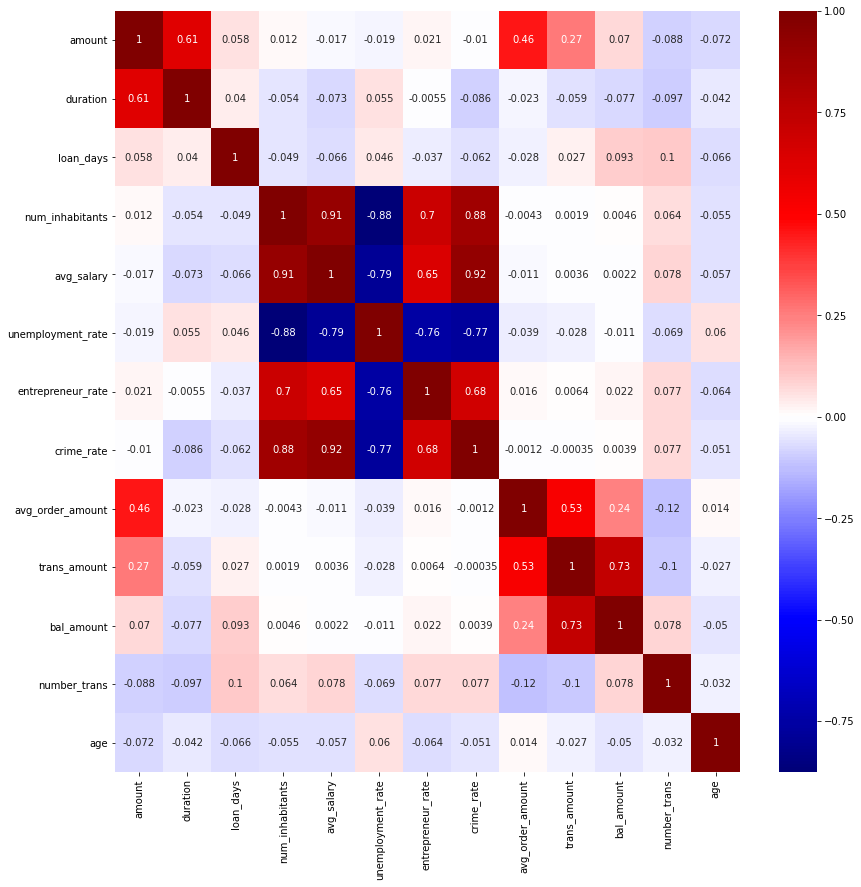

In [14]:
graph.figure(figsize=(14, 14))
sns.heatmap(corr_df, cmap='seismic', center=0, annot=True)
graph.show()

Although some are highly correlated, they do not really make intuitive sense. If we knew the data more, we could have explored further and choose our variables better. But we'll keep everything for now

# Data Preparation
Now we have all the data, we should scale and transform them, so that they are ready when we make our models.

We have categorical and numerical variables. 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, plot_roc_curve
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
y = df['defaulted']
x = df[[col for col in df.columns if col != 'defaulted']]
x_labels = x.columns

print(x.shape, y.shape)

cat_x = x[['frequency', 'region', 'card_type', 'gender']]
num_x = x[[col for col in x if col not in cat_x.columns]].astype(float)

(682, 19) (682,)


In [17]:
# Transform target

y = LabelEncoder().fit_transform(y)

In [18]:
# Transform X 
x_trans = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_x.columns), 
    ('num', StandardScaler(), num_x.columns)
])

x = x_trans.fit_transform(x)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

# Modelling
We can test several models here. Since we have binary data (for target), good options are logistic regressions, decision trees, random forest, Gradient Boosting.

Logistic regressions will provide more statistical robustness. Random Forests are easy to understand and perform better than decision trees (less overfitting for example). Given we do not have a lot of data, we might not need to look into Gradient Boosting for now (but we will if we gave enough time)

In [20]:
def evaluate(model, features=x, true_y=y):
    prediction = model.predict(features)
    print(f'Accuracy score: {accuracy_score(true_y, prediction)}')
    print(f'F1 score:       {f1_score(true_y, prediction)}')
    print(f'ROC AUC score:  {roc_auc_score(true_y, prediction)}')

## 1. Logistic Regression 

Accuracy score: 0.907624633431085
F1 score:       0.3883495145631068
ROC AUC score:  0.6258033698106653


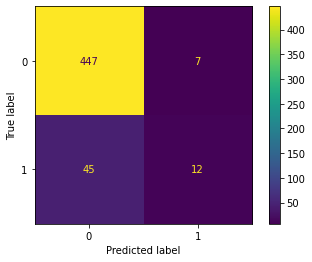

In [21]:
logit_model = LogisticRegression()
logit_model.fit(x_train, y_train)

evaluate(logit_model)

ConfusionMatrixDisplay.from_estimator(logit_model, x_train, y_train)
graph.show()

## 2. Random Forest

Accuracy score: 0.9750733137829912
F1 score:       0.8740740740740741
ROC AUC score:  0.888157894736842


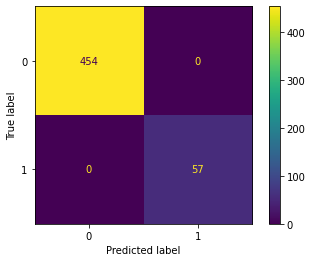

In [22]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

evaluate(rf_model)

ConfusionMatrixDisplay.from_estimator(rf_model, x_train, y_train)
graph.show()

## 3. Gradient Boosting Classifier

Accuracy score: 0.9765395894428153
F1 score:       0.8888888888888888
ROC AUC score:  0.917752301545944


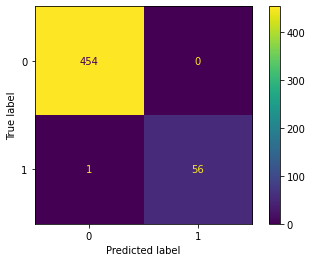

In [23]:
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)

evaluate(gb_model)

ConfusionMatrixDisplay.from_estimator(gb_model, x_train, y_train)
graph.show()

Seems like the random forest is better out of the 3 models we tested. We'll go with the random forest and fine tune it now

In [24]:
rf_model = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        'n_estimators': [20, 100, 200], 
        'max_depth': [None, 10, 25],
        'min_samples_split': [2, 5, 8],
        'max_features': ['auto', 5, 8, 10]
    },
    n_jobs=-1,
    cv=10,
)

rf_model.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 25],
                         'max_features': ['auto', 5, 8, 10],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [20, 100, 200]})

In [25]:
print(rf_model.best_params_)

{'max_depth': None, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [26]:
best_rf_model = rf_model.best_estimator_
evaluate(best_rf_model)

Accuracy score: 0.966275659824047
F1 score:       0.8244274809160306
ROC AUC score:  0.8544380753864861


The model improved slightly. With more time, we could have tested for more parameters

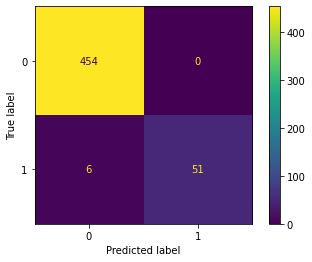

In [27]:
ConfusionMatrixDisplay.from_estimator(best_rf_model, x_train, y_train)
graph.show()

### Let's see how the model performs on the test set now

Accuracy score: 0.9005847953216374
F1 score:       0.2608695652173913
ROC AUC score:  0.5756578947368421


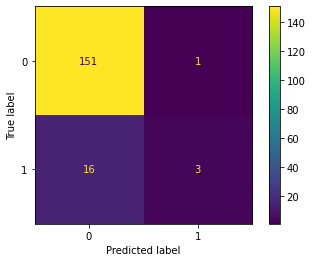

In [28]:
evaluate(best_rf_model, x_test, y_test)

ConfusionMatrixDisplay.from_estimator(best_rf_model, x_test, y_test)
graph.show()

Hmm, not great :(

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x360 with 0 Axes>

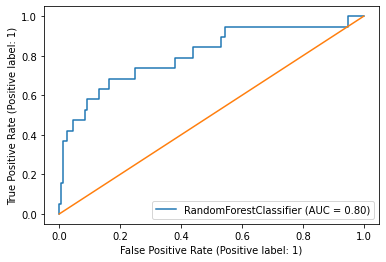

In [29]:
graph.figure(figsize=(12, 5))
plot_roc_curve(best_rf_model, x_test, y_test)
graph.plot([0, 1], [0, 1])
graph.show()

# Important Features

In [30]:
feature_labels = list(x_trans.transformers_[0][1].get_feature_names()) + list(x_trans.transformers_[1][2])
feature_importance = best_rf_model.feature_importances_

features_df = pd.DataFrame({'features': feature_labels, 'importance': feature_importance}).sort_values(by='importance', 
                                                                                                       ascending=False)
display(features_df[:10])

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,importance
29,bal_amount,0.195254
28,trans_amount,0.121841
19,payments,0.106956
17,amount,0.076999
20,loan_days,0.067414
30,number_trans,0.050485
27,avg_order_amount,0.049437
23,avg_salary,0.042845
21,num_inhabitants,0.039397
31,age,0.038672


So the most important variables are the balance the client has, the average transaction amount of the client, payments. Interesting that demographic variables are not that important, but rather the attributes of the client's finances themselves